Attempt to use classification to decide if a stock is going up or down.

In [8]:
import yfinance as yf
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import pickle

import tensorflow as tf
from tensorflow import keras

import indicators as ind

np.set_printoptions(suppress=True, edgeitems=30, linewidth=100000)

In [3]:
df = pd.read_csv("a.csv")

TICKERS = list(df.loc[:, "Symbol"])[:100]

# fetch hists
try:
    with open("hists.dat", "rb") as f:
        hists = pickle.load(f) 

except:
    hists = []
    for x in range(len(TICKERS)):
        print("LOADING TICKER " + str(x) + "/" + str(len(TICKERS)), end="\r")
        hist = yf.Ticker(TICKERS[x]).history(interval="1d", period="10y")
        if not hist.empty and np.sum(np.isnan(hist.loc[:, "Open"].to_numpy())) == 0:
            hist.drop(columns=["Dividends", "Stock Splits"], inplace=True)
            hists.append(hist)
            

NUM_TICK = len(hists)
with open("hists.dat", "wb") as f:
    pickle.dump(hists, f)

In [56]:
def sampleDataset(features, deltas, num_samples, interval_len, feature_size, offset=0):
    # creates samples of data from a dataset
    # returns the intervals, and the target price changes

    feature_samples = np.ndarray((num_samples, interval_len, feature_size))
    delta_samples = np.ndarray((num_samples,))
    for x in range(num_samples):
        start_index = round(x * (features.shape[0] - interval_len - 1 - offset) / num_samples) + offset
        # data_range = data.shape[0] - offset

        # print(start_index, start_index + interval_len)
        # print(features[start_index:start_index + interval_len, :5])

        # print(features[start_index + interval_len, :5])
        # print(deltas[start_index])

        feature_samples[x] = features[start_index:start_index + interval_len]
        delta_samples[x] = deltas[start_index]
    
    return feature_samples, delta_samples

def normalize_data(data, method="one"):
    if method=="one":
        maxes = np.max(data, axis=0)
        mins = np.min(data, axis=0)
        return (data - mins) / (maxes - mins)
    elif method=="zscore":
        mean = np.mean(data, axis=0)
        stdev = np.std(data, axis=0)

        # print(mean, stdev)

        return (data - mean) / stdev
    
    return np.zeros(data.shape)

In [62]:
NUM_SAMPLE = 1500 # Number of samples PER TICKER
INTERVAL = 7
NUM_FEATURE = 8 # open, high, low, close, volume, EMA_S, MACD, RSI

EMA_PERIODS = [12, 26]
MACD_PERIOD = 9
RSI_PERIOD = 14

stock_data = np.ndarray((NUM_TICK, NUM_SAMPLE, INTERVAL, NUM_FEATURE))
delta_data = np.ndarray((NUM_TICK, NUM_SAMPLE))

'''FOR TESTING'''
MMM_means = 0
MMM_stdev = 0
'''           '''

i = 0
for hist in hists:

    '''Remember that EMA truncates the last [period - 1] values, so we need to
       truncate those values from all other features!'''
    
    # calcualte open-close deltas
    opens = hist.loc[:, "Open"].to_numpy()
    closes = hist.loc[:, "Close"].to_numpy()
    deltas = ((closes / opens) - 1)[EMA_PERIODS[1] - 1:]

    # get indicators
    EMA_S = ind.EMA(closes, EMA_PERIODS[0])[EMA_PERIODS[1] - EMA_PERIODS[0]:] # truncate EMA_S shape to match EMA_L
    EMA_L = ind.EMA(closes, EMA_PERIODS[1])
    MACD = ind.MACD(EMA_S, EMA_L)
    RSI = ind.RSI(closes, RSI_PERIOD)[EMA_PERIODS[1] - RSI_PERIOD - 1:]

    ''' FOR TESTING'''
    if i == 0:
        MMM_means = np.mean(hist.to_numpy()[EMA_PERIODS[1] - 1:], axis=0)
        MMM_stdev = np.std(hist.to_numpy()[EMA_PERIODS[1] - 1:], axis=0)
    '''            '''

    # get input data (open, high, low, close, volume, EMA_S, MACD, RSI)
    data = hist.to_numpy()[EMA_PERIODS[1] - 1:]
    data = np.vstack((data.T, EMA_S, MACD, RSI)).T # format: (samples x features)
    normal_data = normalize_data(data, method="zscore") # normalize data along each feature axis

    # print(data[0:10, :5])
    # print(deltas[INTERVAL:INTERVAL+3])
    # print()

    # shift data and deltas to that each delta is aligned with its respective interval
    normal_data = normal_data[:-INTERVAL]
    data = data[:-INTERVAL] # just for hehe hahas
    deltas = deltas[INTERVAL:]

    # print(data[0:10, :5])
    # print(deltas[0])

    data, deltas = sampleDataset(normal_data, deltas, NUM_SAMPLE, INTERVAL, NUM_FEATURE) # format: (samples x interval x features)

    stock_data[i] = data
    delta_data[i] = deltas
    i += 1

# numpy array: (ticker x features x samples)
#              (100 x 8 x 10000)
# input style: (samples x interval x features)
#              (100 * 10000 x 7 x 8)

delta_data = np.where(delta_data > 0, 1, 0) # classify to increase and decrease

In [63]:
hist = hists[0]
# display(hist.tail())

# print(MMM_means)
# print(MMM_stdev)

display(hists[0][-17:-9])
print(stock_data[0, -1, :, :5])
print(delta_data[0, -1])

print()
print(stock_data[0, -1, :, :5] * MMM_stdev + MMM_means)
print(delta_data[0, -1])


display(hists[0][-20:-12])
print(stock_data[0, -3, :, :5])
print(delta_data[0, -3])

print()
print(stock_data[0, -3, :, :5] * MMM_stdev + MMM_means)
print(delta_data[0, -3])

,Open,High,Low,Close,Volume
Date,,,,,
2023-11-24 00:00:00-05:00,95.300003,95.980003,95.120003,95.949997,1059900
2023-11-27 00:00:00-05:00,96.000000,97.459999,95.940002,97.070000,3293900
2023-11-28 00:00:00-05:00,96.919998,99.099998,96.540001,98.510002,4334600
2023-11-29 00:00:00-05:00,99.250000,99.449997,98.120003,98.470001,2581600
2023-11-30 00:00:00-05:00,98.639999,100.080002,98.260002,99.070000,6012500
2023-12-01 00:00:00-05:00,98.839996,100.209999,98.160004,99.849998,2783400
2023-12-04 00:00:00-05:00,100.339996,103.779999,100.230003,103.440002,5030200
2023-12-05 00:00:00-05:00,102.750000,103.000000,101.440002,101.690002,3073400


[[-1.58003249 -1.58687658 -1.55188054 -1.55471587 -0.68656423]
 [-1.5534401  -1.53093281 -1.52053461 -1.51214943  0.17533548]
 [-1.51849003 -1.46894092 -1.49759861 -1.45742118  0.57684803]
 [-1.42997493 -1.45571099 -1.43720025 -1.45894144 -0.09947704]
 [-1.45314841 -1.43189684 -1.43184853 -1.4361381   1.22419875]
 [-1.44555067 -1.42698295 -1.43567115 -1.40649374 -0.02162056]
 [-1.38856675 -1.29203714 -1.35654176 -1.27005326  0.84521752]]
0

[[     95.30000305      95.98000336      95.12000275      95.94999695 1059900.        ]
 [     96.              97.45999908      95.94000244      97.06999969 3293900.        ]
 [     96.91999817      99.09999847      96.54000092      98.51000214 4334600.        ]
 [     99.25            99.44999695      98.12000275      98.47000122 2581600.        ]
 [     98.63999939     100.08000183      98.26000214      99.06999969 6012500.        ]
 [     98.83999634     100.20999908      98.16000366      99.84999847 2783400.        ]
 [    100.33999634     103.

,Open,High,Low,Close,Volume
Date,,,,,
2023-11-20 00:00:00-05:00,95.019997,95.250000,94.459999,94.980003,3333300
2023-11-21 00:00:00-05:00,94.620003,94.760002,93.739998,93.989998,2708700
2023-11-22 00:00:00-05:00,94.970001,95.779999,94.629997,95.370003,2394200
2023-11-24 00:00:00-05:00,95.300003,95.980003,95.120003,95.949997,1059900
2023-11-27 00:00:00-05:00,96.000000,97.459999,95.940002,97.070000,3293900
2023-11-28 00:00:00-05:00,96.919998,99.099998,96.540001,98.510002,4334600
2023-11-29 00:00:00-05:00,99.250000,99.449997,98.120003,98.470001,2581600
2023-11-30 00:00:00-05:00,98.639999,100.080002,98.260002,99.070000,6012500


[[-1.59066973 -1.61447067 -1.57711034 -1.59158112  0.1905364 ]
 [-1.60586521 -1.63299256 -1.60463365 -1.62920693 -0.05044057]
 [-1.59256902 -1.59443674 -1.57061186 -1.57675893 -0.17177784]
 [-1.58003249 -1.58687658 -1.55188054 -1.55471587 -0.68656423]
 [-1.5534401  -1.53093281 -1.52053461 -1.51214943  0.17533548]
 [-1.51849003 -1.46894092 -1.49759861 -1.45742118  0.57684803]
 [-1.42997493 -1.45571099 -1.43720025 -1.45894144 -0.09947704]]
1

[[     95.01999664      95.25            94.45999908      94.98000336 3333300.        ]
 [     94.62000275      94.76000214      93.73999786      93.98999786 2708700.        ]
 [     94.97000122      95.77999878      94.62999725      95.37000275 2394200.        ]
 [     95.30000305      95.98000336      95.12000275      95.94999695 1059900.        ]
 [     96.              97.45999908      95.94000244      97.06999969 3293900.        ]
 [     96.91999817      99.09999847      96.54000092      98.51000214 4334600.        ]
 [     99.25            99.

In [64]:
# Create LSTM model
LEARNING_RATE = 0.001
REG_FACTOR = 0
VAL_RATIO = 0.1

# Define the LSTM model
model = keras.Sequential()
model.add(keras.layers.Input((INTERVAL, NUM_FEATURE)))
model.add(keras.layers.LSTM(units=64, kernel_regularizer=keras.regularizers.l2(REG_FACTOR), return_sequences=False))
model.add(keras.layers.Dense(units=64, activation="relu"))
model.add(keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the model
model.compile(loss=keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

model.build((None, INTERVAL, NUM_FEATURE))
model.summary()

# callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                18688     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 22,913
Trainable params: 22,913
Non-trainable params: 0
_________________________________________________________________


In [70]:
num_epochs = 100
batch_size = 256

indices = np.random.permutation(stock_data.shape[0] * NUM_SAMPLE)
train_data = np.reshape(stock_data, (-1, INTERVAL, NUM_FEATURE))[indices]
target_data = np.reshape(delta_data, (-1))[indices]

print(train_data.shape)
print(target_data.shape)

# Train the model
train_hist = model.fit(train_data, target_data, epochs=num_epochs, batch_size=batch_size, validation_split=VAL_RATIO, callbacks=[])

# Evaluate the model
metrics = model.evaluate(train_data, target_data)



(147000, 7, 8)
(147000,)
Epoch 1/100
517/517 [==============================] - ETA: 0s - loss: 0.6187

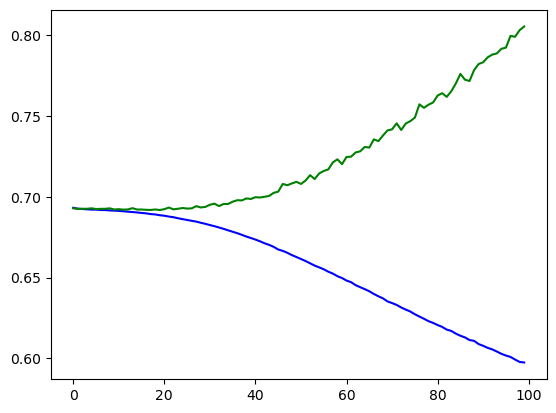

In [66]:
plt.plot(train_hist.history["loss"], color="blue")
plt.plot(train_hist.history["val_loss"], color="green")